# Quick Start Tutorial

GluonTS contains:

* A number of pre-built models
* Components for building new models (likelihoods, feature processing pipelines, calendar features etc.)
* Data loading and processing
* Plotting and evaluation facilities
* Artificial and real datasets (only external datasets with blessed license)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## Datasets

### Provided datasets

GluonTS comes with a number of publicly available datasets.

In [2]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas

In [3]:
print(f"Available datasets: {dataset_names}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

To download one of the built-in datasets, simply call get_dataset with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again the next time around.

In [4]:
dataset = get_dataset("m4_hourly")

In general, the datasets provided by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series.
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

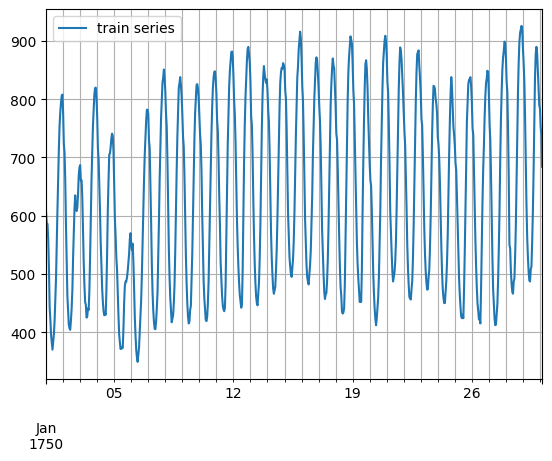

In [5]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

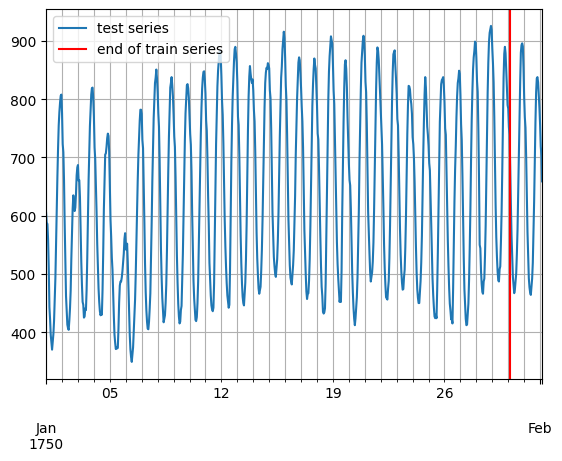

In [6]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [7]:
print(
    f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}"
)
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


### Custom datasets

At this point, it is important to emphasize that GluonTS does not require this specific format for a custom dataset that a user may have. The only requirements for a custom dataset are to be iterable and have a "target" and a "start" field. To make this more clear, assume the common case where a dataset is in the form of a `numpy.array` and the index of the time series in a `pandas.Period` (possibly different for each time series):

In [8]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Period("01-01-2019", freq=freq)  # can be different for each time series

Now, you can split your dataset and bring it in a GluonTS appropriate format with just two lines of code:

In [9]:
from gluonts.dataset.common import ListDataset

In [10]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq,
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset], freq=freq
)

## Training an existing model (`Estimator`)

GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) probabilistic forecasting. Probabilistic forecasts are predictions in the form of a probability distribution, rather than simply a single point estimate.

We will begin with GluonTS's pre-built feedforward neural network estimator, a simple but powerful forecasting model. We will use this model to demonstrate the process of training a model, producing forecasts, and evaluating the results.

GluonTS's built-in feedforward neural network (`SimpleFeedForwardEstimator`) accepts an input window of length `context_length` and predicts the distribution of the values of the subsequent `prediction_length` values. In GluonTS parlance, the feedforward neural network model is an example of an `Estimator`. In GluonTS, `Estimator` objects represent a forecasting model as well as details such as its coefficients, weights, etc.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [11]:
from gluonts.mx import SimpleFeedForwardEstimator, Trainer

In [12]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to construct forecasts.

In [13]:
predictor = estimator.train(dataset.train)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 136.10it/s, epoch=1/5, avg_epoch_loss=5.5]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 143.00it/s, epoch=2/5, avg_epoch_loss=4.86]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 140.70it/s, epoch=3/5, avg_epoch_loss=4.72]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 143.23it/s, epoch=4/5, avg_epoch_loss=4.81]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 144.50it/s, epoch=5/5, avg_epoch_loss=4.72]

## Visualize and evaluate forecasts

With a predictor in hand, we can now predict the last window of the `dataset.test` and evaluate our model's performance.

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The module outputs the forecast sample paths and the `dataset.test` (as python generator objects)

In [14]:
from gluonts.evaluation import make_evaluation_predictions

In [15]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [16]:
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let's start with the list containing the time series, i.e., `tss`. We expect the first entry of `tss` to contain the (target of the) first time series of `dataset.test`.

In [17]:
# first entry of the time series list
ts_entry = tss[0]

In [18]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(
    -1,
)

array([605., 586., 586., 559., 511.], dtype=float32)

In [19]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [20]:
# first 5 values
dataset_test_entry["target"][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

The entries in the `forecast` list are a bit more complex. They are objects that contain all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all this information by simply invoking the corresponding attribute of the forecast object.

In [21]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [22]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00
Frequency of the time series: <Hour>


We can also do calculations to summarize the sample paths, such as computing the mean or a quantile for each of the 48 time steps in the forecast window.

In [23]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [639.66077 658.0511  552.81476 533.2969  493.03867 497.4587  388.23367
 508.86005 488.38263 585.7019  590.5804  633.5566  735.9546  818.53827
 827.5405  896.6119  881.3922  831.70624 836.5081  806.9725  768.7379
 770.90674 725.0249  709.9852  621.17413 587.09485 535.24194 496.24234
 474.26944 523.7688  538.42224 492.28284 497.149   570.52    639.18506
 728.5694  844.8908  842.5762  857.1248  895.1651  911.2351  934.3844
 881.88776 888.31445 887.12085 797.9183  742.78937 698.47845]
0.5-quantile (median) of the future window:
 [651.8985  655.4397  566.98926 542.85333 485.50317 492.54675 403.92365
 513.5063  496.67416 565.9679  585.32837 631.4199  753.55536 828.24176
 829.8248  911.32104 861.32385 828.74243 830.79584 812.5209  767.35565
 762.20795 720.6565  692.8951  614.735   589.99115 536.9734  501.07224
 474.88385 512.0502  522.1414  484.35178 492.1236  578.683   640.3349
 717.25037 825.409   858.3357  853.95703 910.81256 890.8249  946.8613
 893.7431  866.71

`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

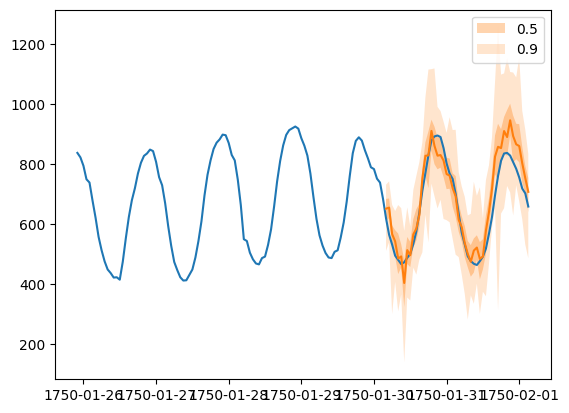

In [24]:
plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

We can also evaluate the quality of our forecasts numerically. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [25]:
from gluonts.evaluation import Evaluator

In [26]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 0it [00:00, ?it/s]

Running evaluation: 414it [00:00, 11210.01it/s]

The aggregate metrics, `agg_metrics`, aggregate both across time-steps and across time series.

In [27]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 10330287.941363767,
    "abs_error": 9888776.191505432,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 3.298529737437924,
    "MAPE": 0.24230639967653486,
    "sMAPE": 0.1844004778050474,
    "MSIS": 64.15294911907903,
    "num_masked_target_values": 0.0,
    "QuantileLoss[0.1]": 4685229.677179908,
    "Coverage[0.1]": 0.10487117552334944,
    "QuantileLoss[0.5]": 9888776.174993515,
    "Coverage[0.5]": 0.5401066827697263,
    "QuantileLoss[0.9]": 7182032.328086851,
    "Coverage[0.9]": 0.8878824476650563,
    "RMSE": 3214.076530103751,
    "NRMSE": 0.4387924392011613,
    "ND": 0.06793661304409888,
    "wQuantileLoss[0.1]": 0.032187869301230805,
    "wQuantileLoss[0.5]": 0.0679366129306608,
    "wQuantileLoss[0.9]": 0.04934108545833773,
    "mean_absolute_QuantileLoss": 7252012.726753425,
    "mean_wQuantileLoss": 0.049821855896743115,
    "MAE_Coverage": 0.39596081588835214,
    "OW

Individual metrics are aggregated only across time-steps.

In [28]:
item_metrics.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,num_masked_target_values,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0,1750-01-30 04:00,3309.237305,2154.689453,31644.0,659.250000,42.371302,1.059428,0.067252,0.064834,0.0,0.068092,13.231213,935.300177,0.041667,2154.689484,0.708333,1459.305225,1.000000
1,1,1750-01-30 04:00,182585.895833,18652.218750,124149.0,2586.437500,165.107988,2.353538,0.159426,0.146121,0.0,0.150241,14.012219,4414.383215,0.270833,18652.218994,0.979167,8807.242969,1.000000
2,2,1750-01-30 04:00,31560.596354,6341.560547,65030.0,1354.791667,78.889053,1.674704,0.087524,0.093271,0.0,0.097517,13.391114,3399.184241,0.000000,6341.560669,0.208333,2718.548511,0.729167
3,3,1750-01-30 04:00,161919.552083,15676.248047,235783.0,4912.145833,258.982249,1.261046,0.065586,0.064962,0.0,0.066486,14.689635,8973.606250,0.062500,15676.248291,0.437500,8183.246777,1.000000
4,4,1750-01-30 04:00,104537.510417,11086.554688,131088.0,2731.000000,200.494083,1.152004,0.085404,0.079762,0.0,0.084573,12.690474,4597.160254,0.083333,11086.554077,0.791667,7307.160693,1.000000


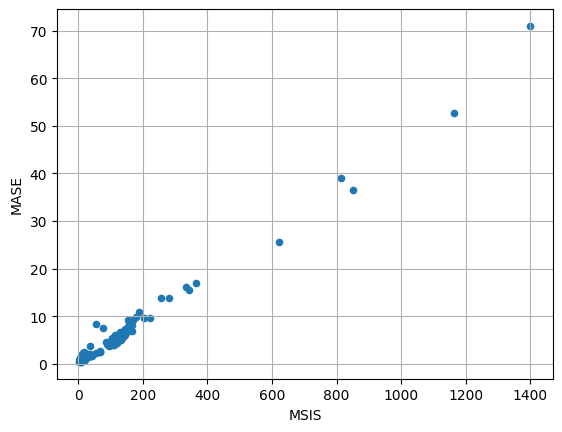

In [29]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()